<a href="https://colab.research.google.com/github/Alsushka-lullo/computational_math/blob/main/StochasticKuramotoProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import os    
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
import sys
sys.setrecursionlimit(1500)

In [ ]:
import torch
from torch import nn
from torchsde import sdeint
import numpy as np
import plotly.express as px
import pandas as  pd

import matplotlib.pyplot as plt

In [ ]:
class KuramoroFunc(nn.Module):
    noise_type = 'general'
    sde_type = 'ito'
    
    def __init__(self, freq, adjacency_matrix, interaction_consts):
        self.freq = freq.float()
        self.adjacency_matrix = adjacency_matrix.float()
        self.interaction_consts = interaction_consts
    
    def f(self, t, phases):
        # phases: n x 1 - omega (all equal)
        phases = phases.unsqueeze(-1) % (2 * np.pi)
        interaction_part = self.adjacency_matrix * torch.sin(phases.transpose(-1, -2) - phases)
        interaction_part = self.interaction_consts.unsqueeze(-1) * interaction_part.sum(-1) / len(phases)
        out_phases = self.freq + interaction_part
        return out_phases
    
    
    def g(self, t, phases):
        # noise = 0.1 * torch.ones_like(phases).unsqueeze(-1)
        noise = torch.randn_like(phases)[:, :, None]
        return noise

In [ ]:
#graph_kwargs = {
    #"num_nodes": 100,
    #"edge_prob": 0.2,
#}

In [ ]:
type_graph = "MY_SYSTEM"

In [ ]:
#adjacency_matrix = generate_graph(**graph_kwargs)
#adjacency_matrix = torch.tensor(adjacency_matrix).cuda()
#напишу своё adjancency matrix ручками, а не из utils
if type_graph == "MY_SYSTEM":
    n = 100
    l_chain = 100
    matr = np.eye(2*n + l_chain, dtype = float)
    #matr = np.zeros((2*n + l_chain, 2*n + l_chain))
    #np.fill_diagonal(matr, 1)
    B = np.eye(l_chain, dtype = float) + np.eye(l_chain, k = 1, dtype = float) + np.eye(l_chain, k = -1, dtype = float)
    adjacency_matrix = np.block([[np.ones((n, n)), np.zeros((n, l_chain)), np.zeros((n, n))], [np.zeros((l_chain, n)), B, np.zeros((l_chain, n))], [np.zeros((n, n)), np.zeros((n, l_chain)), np.ones((n, n))]]) - matr
    adjacency_matrix[n + l_chain - 1][n + l_chain] = 1
    adjacency_matrix[n + l_chain][n + l_chain - 1] = 1
    adjacency_matrix[n - 1][n] = 1
    adjacency_matrix[n][n - 1] = 1
    
        
if type_graph == "COMPLETE_GRAPH":
    n = 1000
    matr = np.zeros((n, n))
    np.fill_diagonal(matr, 1)
    adjacency_matrix = np.ones((1, 1)) - matr
adjacency_matrix = torch.tensor(adjacency_matrix).cuda()
#балда, что не сохранила, но вообще надо матрицу для очень длинной цепочки написать

In [ ]:
#freq = 0.5 * adjacency_matrix.sum(-1).cuda()
#print(freq)
#freq -= freq.mean()
freq = torch.ones_like(adjacency_matrix[0]).cuda()
print(freq)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
interaction_constants = torch.linspace(0.0, 5.0, 40).cuda()
#print(interaction_constants)

In [ ]:
sde = KuramoroFunc(freq, adjacency_matrix, interaction_constants)

In [ ]:
initial_phases = 2 * np.pi * torch.rand(interaction_constants.shape[0], freq.shape[0]).cuda()

In [ ]:
%%time
ys = sdeint(sde, initial_phases, torch.arange(100).float().cuda())

CPU times: user 2min 41s, sys: 426 ms, total: 2min 42s
Wall time: 2min 43s


In [ ]:
#for graph in wolfram
'''
from google.colab import files
import pandas as pd

arrr = np.asarray(ys[-1].cpu())
np.savetxt("ys.csv", arrr, delimiter=',')
files.download("ys.csv")
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
file = open("stochastic_kuramoto0.txt", "w")
file.write(str(ys))
file.close()
'''

In [ ]:
sin_part = torch.mean(torch.sin(ys[-20:]), axis=0)
cos_part = torch.mean(torch.cos(ys[-20:]), axis=0)
order_parametrs = torch.sqrt(cos_part.pow(2) + sin_part.pow(2)).mean(-1)

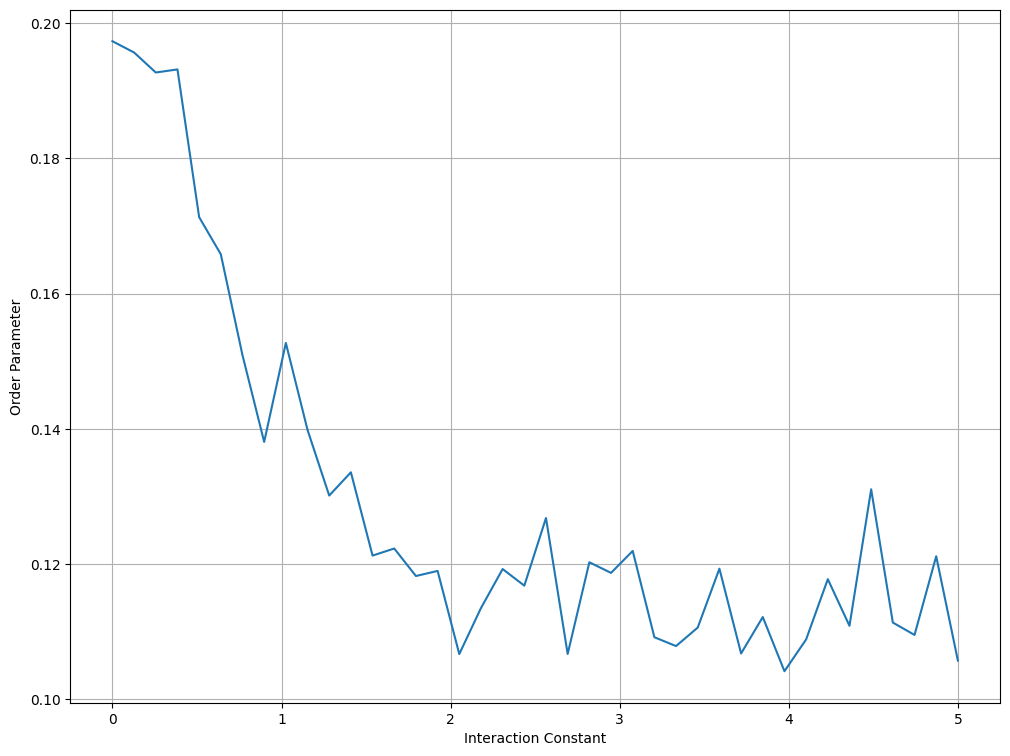

In [ ]:
# n = 100, l = 100

plt.figure(figsize=(12, 9))
plt.plot(interaction_constants.cpu(), order_parametrs.cpu())
plt.xlabel('Interaction Constant')
plt.ylabel('Order Parameter')
plt.grid(True)
plt.show()

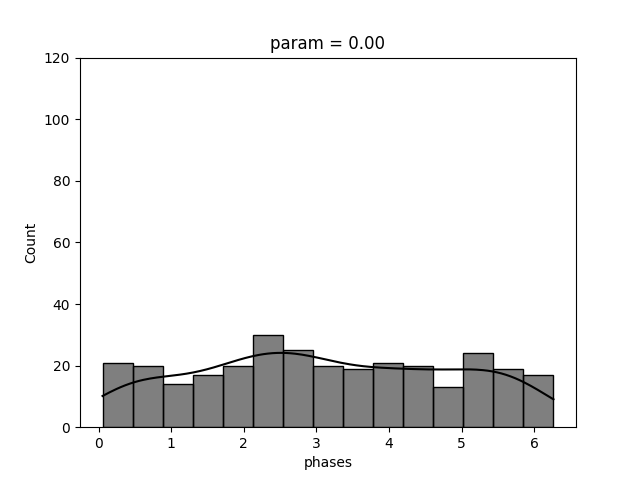

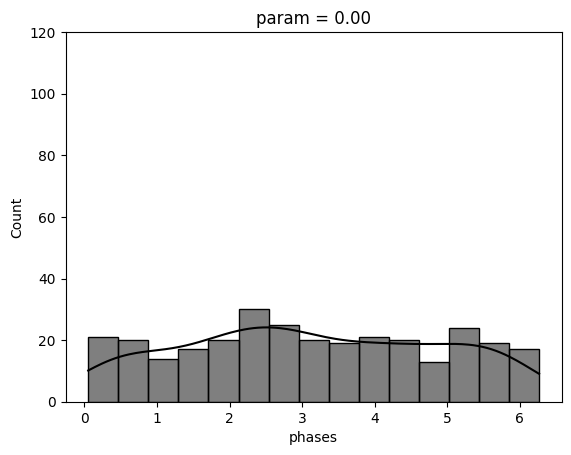

In [ ]:
from matplotlib.animation import FuncAnimation
import seaborn as sns

#phases = ys[-1,1] % (2*np.pi)
fig, ax = plt.subplots()
T = -1
def animate(i):
    phases = ys[T,i] % (2*np.pi)
    ax.clear()
    p = sns.histplot(phases.cpu(), bins = 15, kde=True, color = "black")
    p.set(title=f"param = {interaction_constants[i]:.2f}", xlabel="phases", ylim=(0, 120))
    return p.get_figure()
ani = FuncAnimation(fig, animate, frames=ys.size()[1], interval=500, repeat=True, blit=False)
ani.save('Phases_distribution100basictrue.gif')

from IPython.display import Image
Image(open('Phases_distribution100basictrue.gif','rb').read())

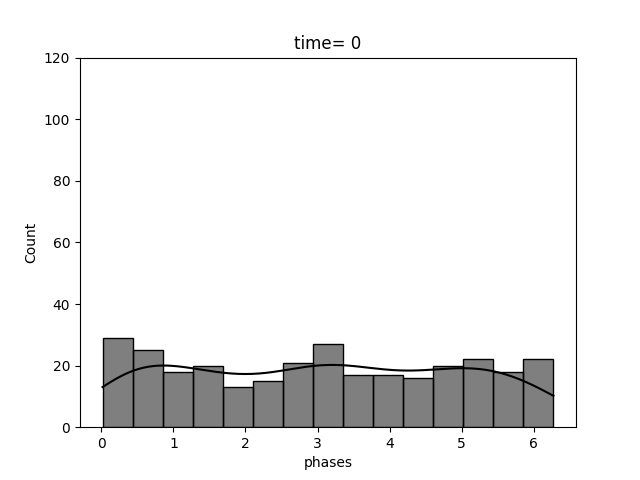

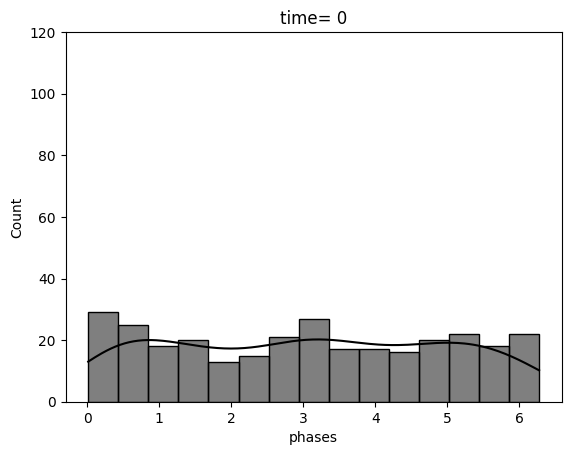

In [ ]:
#phase distribution over time with a fixed parameter

#phases = ys[-1,1] % (2*np.pi)
fig, ax = plt.subplots()
lyambda = -1
def animate(i):
    phases = ys[i,  lyambda] % (2*np.pi)
    ax.clear()
    p = sns.histplot(phases.cpu(), bins = 15, kde=True, color = "black")
    p.set(title=f"time= {i}", xlabel="phases", ylim=(0, 120))
ani = FuncAnimation(fig, animate, frames=ys.size()[0], interval=500, repeat=True, blit=False)
ani.save('Phases_distribution100basic_time_forparam100true.gif')

from IPython.display import Image
Image(open('Phases_distribution100basic_time_forparam100true.gif','rb').read())

# New section

<ipython-input-23-2c80551c9c6a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(phases.cpu(), bins = 8)


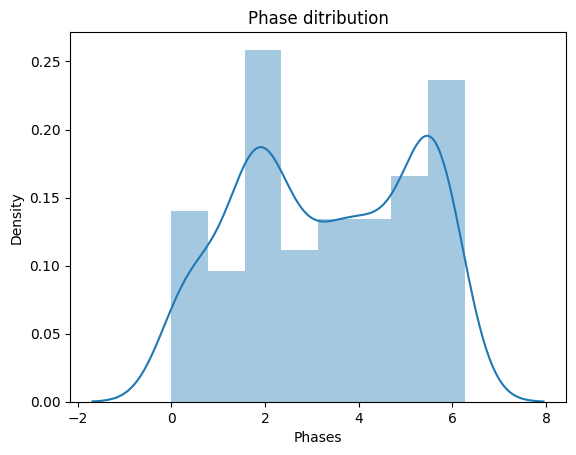

In [ ]:
import seaborn as sns

phases = ys[-1,39] % (2*np.pi)
 
plt.title("Phase ditribution")
plt.xlabel('Phases')

sns_plot = sns.distplot(phases.cpu(), bins = 8)
fig = sns_plot.get_figure()